<a href="https://colab.research.google.com/github/Ansi4Ansi/Google_colab/blob/main/ml_course/ml_b2c2024q2_simkin_HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import plotly.graph_objects as go
import numpy as np

torch.manual_seed(42)

**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2024q2_<фамилия>_HW06.ipynb`` (пример ``ml_b2c2024q2_dral_HW05.ipynb``)
- Зарегистрироваться и залогиниться в сервисе [Everest](https://everest.distcomp.org/)
- Перейти на страницу приложения: [BDT-grader-ML-B2C](https://everest.distcomp.org/apps/BigDataTeam/BDT-grader-ML-B2C)
- Выбрать вкладку Submit Job (если отображается иная).
- Выбрать в качестве “Task” значение: ``HW06:Introduction to neural networks`` (кодовое название для преподвателей: ``nn_intro``)
- Загрузить в качестве “Task solution” файл с решением
- В качестве Access Token указать тот, который был выслан по почте или в телеграм от аккаунта @bdt_manager

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

    https://forms.gle/iY5NRn9UfaZ344rbA

# Вопросы на понимание (10%)

1. Какие меры две меры ошибки мы используем для регрессии и для классификации в нейросетях?
2. В чем задача активаций в нейросетях? Что будет происходить если их не использовать?
3. Как можно понять что при тренировке выбран слишком высокий learning rate? А слишком низкий?
4. У нас есть конволюционный слой с 3х3 фильтром, 32 входными каналами и 128 выходными. Какова размерность весов этого слоя? Сколько всего тренируемых параметров в этом слое?
5. Может ли нейросеть делать правильное предсказание БЕЗ обучения? Почему/почему нет?

Пишите ответы внизу.

# Простые операции на тензорах (5%)

In [ ]:
# создайте тензоры x,y нормально распределенных случайных чисел размером (3, 5, 4) и (4, 7)

x = torch.rand(3, 5, 4)
y = torch.rand(4 ,7)
# проверка
assert x.size() == (3, 5, 4)
assert y.size() == (4, 7)

In [ ]:
# каков будет размер (измерения) произведения этих тензоров? (dot product) запишите ответ в переменную

dot_product_shape = (3, 5, 7)

# проверка
assert (x @ y).size() == dot_product_shape

In [ ]:
# Если мы объединим 2 последних измерения тензора x в одно, каким будет размер тензора х?
# Проверьте себя

new_x_shape = (3, 20)
x_reshaped = x.reshape(new_x_shape)
assert x_reshaped.size() == new_x_shape

torch.Size([3, 20])


In [ ]:
# Другие операции с тензорами (работает так же как numpy), работаем с тензором x

# Максимальное значение в тенсоре
print(f"Max value in x: {x.max()}")

# Среднее значение по второму измерению (hint: индексация с нуля)
print(f"Mean value in dim 2:\n{x.mean(axis=1)}")

Max value in x: 0.9863913059234619
Mean value in dim 2:
tensor([[0.54, 0.56, 0.46, 0.52],
        [0.65, 0.48, 0.45, 0.50],
        [0.64, 0.59, 0.49, 0.49]])


# Автоматическая дифференциация (10%)

Одна из главных фишек PyTorch и других библиотек для Deep Learning заключается в очень быстром расчете производных и градиентов.

Создайте функцию `def f(x:torch.Tensor) -> torch.Tensor:` вида

$x^3 - 3x^3 - 10x^2 - 3x + 50$

Посчитайте градиенты этой функции на промежутке (-2, 8) с шагом 0.1 (или меньшим, для красоты)

Воспользуйтесь функцией `plot_derivative_results` для построения графика

In [ ]:
def f(x: torch.Tensor) -> torch.Tensor:
    return -2*x*x*x - 10*x*x -3*x + 50
x = torch.arange(-2, 8, 0.1)
y = f(x)
grads = torch.gradient(y)
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='f(x)=x^3-3x^3-10x^2-50', opacity=0.7))
fig.add_trace(go.Scatter(x=x, y = grads[0], mode='lines', name='grad(f(x))', opacity=0.7))
fig.update_layout(title='Function and grad', width=800, height=600, xaxis_title='x', yaxis_title='f(x), grad(f(x))')
fig.show()
# постройте график функции f(x) и ее градиента



## NN in PyTorch 75%

Основная часть этого домашнего задания будет основана на создании нейросетей для датасета CIFAR10.
Мы создадим и натренируем 3 модели:
1. Полносвязная нейросеть (Fully Connected). 2 скрытых слоя размером 512 и 128 нейронов. (25%)
2. Сверточная нейросеть (CNN). 3 сверточных слоя с макс пуллингом и 2 полносвязных слоя. (25%)
3. Крутая сверточная нейросеть (CNN). Архитектура как вторая, но со всеми приемами которые мы разбирали (Dropout, BatchNorm, Early Stopping, Weight Decay). (25%)

### Функции для тренировки и тестирования

Вам нужно будет создать 4 функции, `get_dataloaders` `get_accuracy`, `train_model`, `test_model`.

### Загрузка данных

Сначала нам надо создать функцию для загрузки данных `get_dataloaders`. Порядок действий:

1. Создать base_transforms. Они переводят картинку в тензор и нормализуют его.
2. Создать train_transforms. Они добавляют аугментации для тренировочного датасета.
3. Загрузить тренировочный и тестовый датасеты (`torchvision.datasets.CIFAR10`).
4. Разделить тренировочный датасет на тренировочный и валидационный. Для этого можно использовать `torch.utils.data.random_split`, 20 процентов тренировочных картинок должны попасть в валидационный датасет.
5. Создать даталоадеры для тренировочного, валидационного и тестового датасетов. Для тренировочного датасета `shuffle=True`, для остальных `shuffle=False`.
6. Вернуть тренировочный, валидационный и тестовый даталоадеры.


`num_workers`, `batch_size` и `pin_memory` это параметры даталоадеров, которые могут повлиять на скорость загрузки данных. Почитайте про них в документации PyTorch.

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


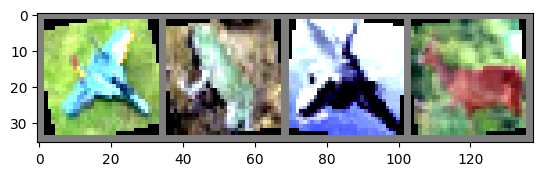

In [5]:
import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def get_dataloaders(
    transform: T.Compose = T.Compose([]),
    batch_size: int = 256,
    num_workers: int = 8,
    pin_memory: bool = True,
    val_fraction: float = 0.2,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    base_transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    train_transform =  T.Compose([T.RandomResizedCrop(32, scale=(0.9, 1.1), antialias=True),
                                  T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                  T.RandomRotation(15)])
    transform = T.Compose([train_transform, base_transform])

    # load the data
    trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=base_transform)

    val_size = int(0.2 * len(trainset))
    train_size = len(trainset) - val_size
    trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return trainloader, valloader, testloader

# проверка
batch_size = 4
trainloader, valloader, testloader = get_dataloaders(batch_size=batch_size)
images, labels = next(iter(trainloader))
assert images.size() == (batch_size, 3, 32, 32)
assert labels.size() == (batch_size,)

# / 2 + 0.5 - это чтобы перевести значения из диапазона [-1, 1] в [0, 1]
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0).numpy() / 2 + 0.5)


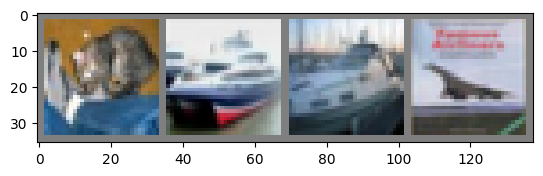

In [ ]:
images, labels = next(iter(testloader))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0).numpy() / 2 + 0.5)

#### `get_accuracy`

Функция должна считать точность (количество правильных ответов / общее количество ответов). Пригодятся `tensor.argmax`, сравнение тензоров, `tensor.item`, `tensor.sum`.

In [6]:
def get_accuracy(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """
    Outputs - предсказания модели (batch_size, n_classes)
    Labels - истинные значения (batch_size, 1)
    """
    preds = outputs.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = len(labels)
    acc = correct / total
    return acc

# проверка
outputs = torch.tensor([[0.1, 0.2, 0.7], [0.9, 0.05, 0.05], [0.2, 0.2, 0.6]])
labels = torch.tensor([2, 0, 2])

assert get_accuracy(outputs, labels) == 1

#### `train_model`

Основная функция для тренировки модели. На вход подается модель, даталоадеры для тртренировочного и валидационного датасетов.
На ваше усмотрения можете добавить все гиперпараметры, которые считаете нужными (learning rate, num epochs, weight decay etc).

Порядок действий:

1. Перевести модель в режим тренировки
2. Создать критерион для подсчета ошибки
3. Создать оптимизатор (Adam)
4. Переместить модель на gpu (если доступно)
5. Создать словарь для метрик (train_loss, train_acc, val_loss, val_acc)
6. Создать цикл для количества эпох
7. Внутри цикла создать цикл для тренировочного и валидационного даталоадеров
8. Внутри цикла для тренировочного даталоадера:
    1. Обнулить градиенты
    2. Переместить данные на gpu
    3. Посчитать предсказания
    4. Посчитать ошибку
    5. Посчитать градиенты
    6. Сделать шаг оптимизатора
    7. Сохранить метрики
 9. Внутри цикла для валидационного даталоадера:
    1. Перевести модель в режим валидации
    2. Посчитать предсказания
    3. Посчитать ошибку
    4. Сохранить метрики

In [7]:
from torch import nn
from collections import defaultdict

def get_string_output(epoch: int, metrics:dict[str, list]) -> str:
    """Print the epoch results"""
    train_loss = metrics['train_loss'][epoch]
    val_loss = metrics['val_loss'][epoch]
    train_acc = metrics['train_acc'][epoch]
    val_acc = metrics['val_acc'][epoch]
    loss_string = f"[Epoch {epoch + 1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
    acc_string = f"Train Accuracy: {train_acc * 100:.2f}%, Val Accuracy: {val_acc * 100:.2f}%"
    return loss_string + acc_string

def train_model(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    num_epochs: int = 10,
    lr: float = 1e-3,
) -> dict[str, list[float]]:
    metrics = dict(train_loss=[], val_loss=[], train_acc=[], val_acc=[])
    # move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # init loss, optimiser
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        # save metrics from each batch to calculate mean per epoch
        epoch_metrics = defaultdict(list)
        model.train()
        # Train loop
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            acc = get_accuracy(outputs, labels)
            epoch_metrics['train_acc'].append(acc)
            epoch_metrics['train_loss'].append(loss.item())

        # Validation loop
        model.eval()
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                acc = get_accuracy(outputs, labels)
                epoch_metrics['val_acc'].append(acc)
                epoch_metrics['val_loss'].append(loss.item())
        # Housekeeping
        for k,v in epoch_metrics.items():
            metrics[k].append(np.mean(v))
        print(get_string_output(epoch, metrics))
    return metrics

#### `test_model`

Функция для тестирования модели. На вход подается модель и даталоадер для тестового датасета.

Порядок действий похож на `train_model`, но с некоторыми отличиями:

* Не нужно обновлять веса модели
* Не нужно считать градиенты
* Соответсвенно, не нужен оптимизатор
* Нет цикла для эпохов
* Только один цикл для даталоадера
  
Функция должна вернуть точность и лосс на тестовом датасете.

In [8]:
def test_model(model: nn.Module, testloader: DataLoader) -> tuple[float, float]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    acc = []
    loss_report = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc.append(get_accuracy(outputs, labels))
            loss_report.append(loss.item())
    return np.mean(loss_report), np.mean(acc)

#### Проверка функций

После этого можно проверить функции `train_model` и `test_model`.
Для этого у вас есть модель `BadModel` (что она делает?).

Попробуйте "натренировать" эту модель на одной эпохе и проверить работоспособность функций.

In [ ]:
class BadModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(1, 10)

    def forward(self, x):
        xmean = x.mean(dim=(1, 2, 3)).unsqueeze(1)
        x = self.layer(xmean)
        return x


trainloader, valloader, testloader = get_dataloaders()
bad_model = BadModel()
train_metrics = train_model(bad_model, trainloader, valloader, num_epochs=5)
test_loss, test_acc = test_model(bad_model, testloader)
print(f"Test Loss: {test_loss:.4f}, Test acc: {test_acc * 100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
[Epoch 1] Train Loss: 2.4256, Val Loss: 2.3995, Train Accuracy: 10.00%, Val Accuracy: 10.21%
[Epoch 2] Train Loss: 2.3710, Val Loss: 2.3530, Train Accuracy: 9.98%, Val Accuracy: 10.22%
[Epoch 3] Train Loss: 2.3344, Val Loss: 2.3233, Train Accuracy: 10.09%, Val Accuracy: 10.36%
[Epoch 4] Train Loss: 2.3088, Val Loss: 2.3024, Train Accuracy: 10.35%, Val Accuracy: 10.77%
[Epoch 5] Train Loss: 2.2922, Val Loss: 2.2884, Train Accuracy: 10.94%, Val Accuracy: 11.47%
Test Loss: 0.1215, Test acc: 12.15%


### Создание моделей

Если все прошло успешно, можно переходить к созданию моделей.

#### Полносвязная нейросеть

Параметры - 2 скрытых слоя размером 512 и 128 нейронов. Активация - ReLU.

Используйте `nn.Linear`, `torch.relu`, `tensor.flatten` или `tensor.view`.

Натренируйте модель на 30 эпохах. Посмотрите на точность на тренировочном, валидационном и тестовом датасетах.

Постройте график лосса и точности на тренировочном и валидационном датасетах.

**Вопросы:**

1. Какая точность на тестовом датасете?
2. Как быстро сходится модель?
3. Происходит ли переобучение?
4. Если да, то в какой момент?

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, image_size : int = 32, channels: int = 3): #CIFAR10 - image size 32x32x3
        super().__init__()

        self.fc1 = nn.Linear(image_size * image_size * channels, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x.flatten(1, -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


trainloader, valloader, testloader = get_dataloaders()
model = SimpleNN()
train_metrics_simple = train_model(model, trainloader, valloader, num_epochs=30)
test_loss_simple, test_acc_simple = test_model(model, testloader)
print(f"Test Loss: {test_loss_simple:.4f}, Test acc: {test_acc_simple * 100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
[Epoch 1] Train Loss: 1.7641, Val Loss: 1.6464, Train Accuracy: 37.23%, Val Accuracy: 41.71%
[Epoch 2] Train Loss: 1.5800, Val Loss: 1.5635, Train Accuracy: 44.00%, Val Accuracy: 44.60%
[Epoch 3] Train Loss: 1.4974, Val Loss: 1.5188, Train Accuracy: 46.65%, Val Accuracy: 46.40%
[Epoch 4] Train Loss: 1.4415, Val Loss: 1.4928, Train Accuracy: 48.99%, Val Accuracy: 47.06%
[Epoch 5] Train Loss: 1.3988, Val Loss: 1.4772, Train Accuracy: 50.60%, Val Accuracy: 47.91%
[Epoch 6] Train Loss: 1.3605, Val Loss: 1.4473, Train Accuracy: 51.62%, Val Accuracy: 50.03%
[Epoch 7] Train Loss: 1.3312, Val Loss: 1.4446, Train Accuracy: 52.48%, Val Accuracy: 49.57%
[Epoch 8] Train Loss: 1.3060, Val Loss: 1.4347, Train Accuracy: 53.83%, Val Accuracy: 49.80%
[Epoch 9] Train Loss: 1.2807, Val Loss: 1.4107, Train Accuracy: 54.70%, Val Accuracy: 50.23%
[Epoch 10] Train Loss: 1.2590, Val Loss: 1.4478, Train Accuracy: 55.38%, Val Accuracy: 

In [11]:
test_loss_simple, test_acc_simple = test_model(model, testloader)
print(f"Test Loss: {test_loss_simple:.4f}, Test acc: {test_acc_simple * 100:.2f}%")

Test Loss: 1.4996, Test acc: 51.90%


In [13]:
def plot_accuracy_loss(p_train_metrics : defaultdict(list)) :
  fig = go.Figure()
  x = x=torch.arange(1, len(p_train_metrics['train_acc']))
  fig.add_trace(go.Scatter(x=x, y=p_train_metrics['train_acc'], mode='lines', name='Train accuracy', opacity=0.7))
  fig.add_trace(go.Scatter(x=x, y=p_train_metrics['val_acc'], mode='lines', name='Validation accuracy', opacity=0.7))
  fig.add_trace(go.Scatter(x=x, y=p_train_metrics['train_loss'], mode='lines', name='Train loss', opacity=0.7))
  fig.add_trace(go.Scatter(x=x, y=p_train_metrics['val_loss'], mode='lines', name='Validation loss', opacity=0.7))
  fig.update_layout(title='Accuracy & loss', width=800, height=600, xaxis_title='Epoch', yaxis_title='Accuracy & loss')
  fig.show()

plot_accuracy_loss(train_metrics_simple)

#### Сверточная нейросеть

Параметры - 3 сверточных слоя с макс пуллингом и 2 полносвязных слоя. Активацонная функция тоже ReLU.

Используйте `nn.Conv2d`, `nn.MaxPool2d`, остальные функции как в предыдущей модели.

Для сверточных слоев используйте `kernel_size=3`, `padding=1`, `stride=1`. Для макс пуллинга `kernel_size=2`, `stride=2`.

Натренируйте модель на 30 эпохах. Посмотрите на точность на тренировочном, валидационном и тестовом датасетах.

Постройте график лосса и точности на тренировочном и валидационном датасетах.

**Вопросы:**

1. Какая точность на тестовом датасете?
2. Как быстро сходится модель?
3. Происходит ли переобучение?
4. Если да, то в какой момент?
5. Какая модель лучше, полносвязная или сверточная?

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, image_size : int = 32, channels: int = 3):
        super().__init__()
        self.image_size = image_size
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 128 * 4, 512)

        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.flatten(1, -1)
        #x = x.view(-1, 128 * 128 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


trainloader, valloader, testloader = get_dataloaders()
model = SimpleCNN()
train_metrics_simple_cnn = train_model(model, trainloader, valloader, num_epochs=30)
test_loss_simple_cnn, test_acc_simple_cnn = test_model(model, testloader)
print(f"Test Loss: {test_loss_simple_cnn:.4f}, Test acc: {test_acc_simple_cnn * 100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



[Epoch 1] Train Loss: 1.7013, Val Loss: 1.4773, Train Accuracy: 37.60%, Val Accuracy: 46.14%
[Epoch 2] Train Loss: 1.3592, Val Loss: 1.3127, Train Accuracy: 50.87%, Val Accuracy: 53.28%
[Epoch 3] Train Loss: 1.1948, Val Loss: 1.1444, Train Accuracy: 56.89%, Val Accuracy: 59.18%
[Epoch 4] Train Loss: 1.0748, Val Loss: 1.0634, Train Accuracy: 61.89%, Val Accuracy: 62.66%
[Epoch 5] Train Loss: 0.9738, Val Loss: 0.9835, Train Accuracy: 65.72%, Val Accuracy: 65.19%
[Epoch 6] Train Loss: 0.8933, Val Loss: 0.9309, Train Accuracy: 68.74%, Val Accuracy: 67.23%
[Epoch 7] Train Loss: 0.8380, Val Loss: 0.9186, Train Accuracy: 70.43%, Val Accuracy: 67.97%
[Epoch 8] Train Loss: 0.7682, Val Loss: 0.9106, Train Accuracy: 73.03%, Val Accuracy: 68.51%
[Epoch 9] Train Loss: 0.7251, Val Loss: 0.8819, Train Accuracy: 74.62%, Val Accuracy: 69.49%
[Epoch 10] Train Loss: 0.6827, Val Loss: 0.8671, Train Accuracy: 76.04%, Val Accuracy: 69.84%
[Epoch 11] Train Loss: 0.6318, Val Loss: 0.8351, Train Accuracy: 77.7

In [15]:
plot_accuracy_loss(train_metrics_simple_cnn)

#### Крутая сверточная нейросеть

Задание аналогично предыдущему, но добавьте все приемы, которые мы разбирали (Dropout, BatchNorm, Early Stopping, Weight Decay, Data Augmentation).
Возможно Вам придется переписать функции `get_dataloaders`, `train_model` и `test_model`.

Цель - точность в 80% на тестовом датасете. Ограничение в 30 эпох.

In [27]:
def train_model_cnn(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 1e-3,
    weight_decay = 1e-2,
) -> dict[str, list[float]]:
    metrics = dict(train_loss=[], val_loss=[], train_acc=[], val_acc=[])
    # move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # init loss, optimiser
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    learning_rate_decay_factor = 0.96
    learning_rate_decay_step = 3
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=learning_rate_decay_factor, last_epoch=-1)

    for epoch in range(num_epochs):
        # save metrics from each batch to calculate mean per epoch
        epoch_metrics = defaultdict(list)
        model.train()
        # Train loop
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            acc = get_accuracy(outputs, labels)
            epoch_metrics['train_acc'].append(acc)
            epoch_metrics['train_loss'].append(loss.item())

        if epoch % learning_rate_decay_step == 0:
            lr_scheduler.step()
        print(f'Epoch {epoch} learning rate {lr_scheduler.get_last_lr()}')

        # Validation loop
        model.eval()
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                acc = get_accuracy(outputs, labels)
                epoch_metrics['val_acc'].append(acc)
                epoch_metrics['val_loss'].append(loss.item())
        # Housekeeping
        for k,v in epoch_metrics.items():
            metrics[k].append(np.mean(v))
        print(get_string_output(epoch, metrics))
    return metrics

In [30]:
class ModifiedCNN(nn.Module):
    def __init__(self, image_size : int = 32, channels: int = 3, p_dropout: float = 0.25):
        super().__init__()
        self.image_size = image_size
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch32 = nn.BatchNorm2d(32)
        self.batch64 = nn.BatchNorm2d(64)
        self.batch128 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(p = p_dropout)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.pool(torch.relu(self.batch32(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch64(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch128(self.conv3(x))))
        x = self.dropout(x)
        x = x.flatten(1, -1)
        #x = x.view(-1, 128 * 128 * 32)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


trainloader, valloader, testloader = get_dataloaders()
model = ModifiedCNN(p_dropout = 0.2)
train_metrics_modified_cnn = train_model_cnn(model, trainloader, valloader, num_epochs=30)
test_loss_modified_cnn, test_acc_modified_cnn = test_model(model, testloader)
print(f"Test Loss: {test_loss_modified_cnn:.4f}, Test acc: {test_acc_modified_cnn * 100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 0 learning rate [0.00096]
[Epoch 1] Train Loss: 1.6082, Val Loss: 1.4062, Train Accuracy: 40.65%, Val Accuracy: 48.43%
Epoch 1 learning rate [0.00096]
[Epoch 2] Train Loss: 1.3025, Val Loss: 1.2261, Train Accuracy: 52.74%, Val Accuracy: 56.50%
Epoch 2 learning rate [0.00096]
[Epoch 3] Train Loss: 1.1758, Val Loss: 1.0960, Train Accuracy: 57.96%, Val Accuracy: 60.71%
Epoch 3 learning rate [0.0009216]
[Epoch 4] Train Loss: 1.1028, Val Loss: 1.0793, Train Accuracy: 61.20%, Val Accuracy: 62.73%
Epoch 4 learning rate [0.0009216]
[Epoch 5] Train Loss: 1.0248, Val Loss: 0.9525, Train Accuracy: 63.93%, Val Accuracy: 66.33%
Epoch 5 learning rate [0.0009216]
[Epoch 6] Train Loss: 0.9705, Val Loss: 0.9115, Train Accuracy: 66.03%, Val Accuracy: 67.95%
Epoch 6 learning rate [0.0008847359999999999]
[Epoch 7] Train Loss: 0.9427, Val Loss: 0.8857, Train Accuracy: 66.99%, Val Accuracy: 68.85%
Epoch 7 learning rate [0.0008

In [41]:
plot_accuracy_loss(train_metrics_modified_cnn)

In [25]:
fig = go.Figure()
x = x=torch.arange(1, len(train_metrics_simple['train_acc']))
fig.add_trace(go.Scatter(x=x, y=train_metrics_simple['train_acc'], mode='lines', name='Train accuracy simple', opacity=0.7))
fig.add_trace(go.Scatter(x=x, y=train_metrics_simple['val_acc'], mode='lines', name='Validation accuracy simple', opacity=0.7))
fig.add_trace(go.Scatter(x=x, y=train_metrics_simple_cnn['train_acc'], mode='lines', name='Train accuracy CNN', opacity=0.7))
fig.add_trace(go.Scatter(x=x, y=train_metrics_simple_cnn['val_acc'], mode='lines', name='Validation accuracy CNN', opacity=0.7))
fig.add_trace(go.Scatter(x=x, y=train_metrics_modified_cnn['train_acc'], mode='lines', name='Train accuracy mod CNN', opacity=0.7))
fig.add_trace(go.Scatter(x=x, y=train_metrics_modified_cnn['val_acc'], mode='lines', name='Validation accuracy mod CNN', opacity=0.7))
fig.update_layout(title='Accuracy ', width=800, height=600, xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

## Решил ДЗ - дай обратную связь ;)

Надеемся, было интересно и полезно.

Пожалуйста, оставьте обратную связь по этому домашнему заданию: https://forms.gle/iY5NRn9UfaZ344rbA